In [13]:
import nltk
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /home/jovyan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# for loop

In [1]:
def for_loop(iterations = 100):
    
    a = 0
    for i in range(iterations):
        
        a = a+1
        
    return a

In [2]:
%%time
res = for_loop(iterations = 10_000_000)

CPU times: user 626 ms, sys: 0 ns, total: 626 ms
Wall time: 622 ms


# stemming

## create and save data

In [16]:
from nltk.corpus import gutenberg
data = gutenberg.raw('shakespeare-hamlet.txt')
data = data.replace("\n", " ")
data = data.replace("  ", " ")

In [13]:
# with open('data/shakespeare_hamlet.txt', 'w') as f:
#     f.write(data)

## reading the data

In [1]:
# with open('data/shakespeare_hamlet.txt', 'r') as file:
#     data = file.read()

In [8]:
data = ' '.join([data] * 10)

In [9]:
data[:500] + "..."

"[The Tragedie of Hamlet by William Shakespeare 1599]  Actus Primus. Scoena Prima. Enter Barnardo and Francisco two Centinels.  Barnardo. Who's there?  Fran. Nay answer me: Stand & vnfold your selfe   Bar. Long liue the King   Fran. Barnardo?  Bar. He   Fran. You come most carefully vpon your houre   Bar. 'Tis now strook twelue, get thee to bed Francisco   Fran. For this releefe much thankes: 'Tis bitter cold, And I am sicke at heart   Barn. Haue you had quiet Guard?  Fran. Not a Mouse stirring  ..."

# stemming using python

In [10]:
import nltk
from nltk.stem import PorterStemmer

In [11]:
porter = PorterStemmer()

In [17]:
%%time
stem_words = []
nltk_tokens = nltk.word_tokenize(data)
for token in nltk_tokens:    
    new_token = porter.stem(token)
    stem_words.append(new_token)

CPU times: user 1.22 s, sys: 3.85 ms, total: 1.23 s
Wall time: 1.22 s


## stemming using julia

In [3]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [22]:
from julia import Main

In [23]:
jl.using("TextAnalysis")

### run whole expression

In [25]:
%%time
Main.data = data
Main.token_data = jl.eval("tokens_data = TokenDocument(data) ; return(tokens_data)")
stem_list = jl.eval("stem!(tokens_data);stem_tokens_data =  tokens(tokens_data) ; return(stem_tokens_data)")

CPU times: user 619 ms, sys: 140 µs, total: 619 ms
Wall time: 611 ms


### run with magics

In [26]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [28]:
%%time
tokens = %julia TokenDocument($data)
%julia stem!($tokens)
stem_list = %julia tokens($tokens)

CPU times: user 943 ms, sys: 19.8 ms, total: 962 ms
Wall time: 950 ms


### using julia script

In [29]:
%%time

jl.eval('include("julia_stemming.jl")')
Main.data = data
stem_list = jl.eval("stemming_document(data)")

JuliaError: Exception 'could not open file /opt/code/julia_stemming.jl' occurred while calling julia code:
include("julia_stemming.jl")

# Speed test stemming

In [35]:
import time
import nltk
from nltk.stem import PorterStemmer

porter = PorterStemmer()

In [31]:
def stemming_python(data):
    
    stem_words = []
    nltk_tokens = nltk.word_tokenize(data)
    for token in nltk_tokens:    
        new_token = porter.stem(token)
        stem_words.append(new_token)
        
    return stem_words

In [39]:
time_list_python = []
time_list_julia = []
dataset_length = []

duplicates_list = [1,2,5,10]
for t in duplicates_list:
    data_repeat = ' '.join([data] * t)
    dataset_length.append(len(data_repeat))
    
    time_start_python = time.perf_counter()
    
    stemming_python(data_repeat)
        
    time_end_python = time.perf_counter()

    query_time_python = time_end_python - time_start_python
    time_list_python.append(query_time_python)
    
    
    time_start_julia = time.perf_counter()
    
    Main.data_repeat = data_repeat
    jl.eval("stemming_document(data_repeat)")
        
    time_end_julia = time.perf_counter()

    query_time_julia = time_end_julia - time_start_julia
    time_list_julia.append(query_time_julia)
    
    print(t)

1
2
5
10


In [40]:
time_list_python

[1.5151925739919534, 3.0320599949918687, 7.573481294995872, 15.12069941200025]

In [41]:
time_list_julia

[0.4815222720062593, 0.8485602569999173, 2.066029820998665, 4.078304809008841]

In [42]:
dataset_length

[160841, 321683, 804209, 1608419]

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
df = pd.DataFrame({"running_time_python" : time_list_python,
                   "running_time_julia" :  time_list_julia,
                   "dataset_length" : dataset_length})
df.set_index("dataset_length", inplace=True)

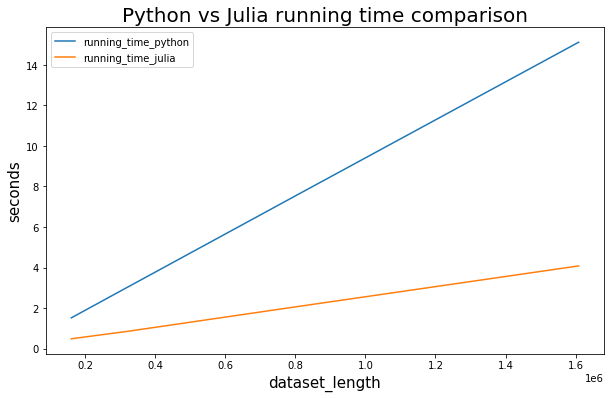

In [64]:
df.plot(figsize = (10,6))
plt.title("Python vs Julia running time comparison", fontsize = 20 )
plt.ylabel('seconds', fontsize = 15)
plt.xlabel('dataset_length', fontsize = 15)
plt.show()